<a href="https://colab.research.google.com/github/rahiakela/deep-learning--from-basics-to-practice/blob/24-keras-part-2/recurrent_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks

Recurrent neural networks, or RNNs, are great for sequential data. The MNIST image data we’ve been using is not sequential, because there’s no order to the images.

Sequential data, on the other hand, is inherently ordered.

Classic examples are daily temperatures, the daily price of a stock, and the hourly height of a tide. There’s also data that’s ordered, but not in time, such as children lined up by height, shelved library books, and the colors of the rainbow.

In all of these phenomena, we want to use the information in the
sequence of inputs to help us produce new output.

In RNN terminology, we still have a dataset made of samples, where each sample contains multiple features. But now each feature contains multiple values, called time steps. Recall that we can also think of “time steps” as “series of measurements for a given feature.”


## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras import backend as keras_backend
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import math

keras_backend.set_image_data_format('channels_last')

TensorFlow 2.x selected.


## Generating Sequence Data

There are lots of sequential datasets available, but some of them are complicated or hard to draw. So let’s make our own simple dataset that we can easily draw and interpret.

Our little curve-building routine takes three other arguments. The first is an integer called number_of_steps which tells it how many points to generate. 

The second is a float called d_theta that tells the routine the spacing of the samples (the name comes from thinking of the sine wave as based on an angle, which is often written with the lower-case Greek letter θ (theta). 

Finally, skip_steps is an integer that provides an offset to the starting point, so we don’t always begin at 0.

This is useful for creating the test data, which can start far to the right of the training data.

In [0]:
def sum_of_sines(number_of_steps, d_theta, skip_steps, freqs, amps, phases):
  '''
  Add together multiple sine waves and return a list of values that is
  number_of_steps long. d_theta is the step (in radians) between samples.
  skip_steps determines the start of the sequence. The lists freqs, amps,
  and phases should all the same length (but we don't check!)
  '''

  values = []
  for step_num in range(number_of_steps):
    angle = d_theta * (step_num + skip_steps)
    sum = 0
    for wave in range(len(freqs)):
      y = amps[wave] * math.sin(freqs[wave] * (phases[wave] + angle))
      sum += y
    values.append(sum)
  return np.array(values)

Data set 0 is a gentle sum of two waves. We made one wave twice the speed of the other by setting freqs to (1,2), the second wave twice as high as the first by setting amps to (1,2), and started both waves at 0 by setting phases to (0,0), Our training data came from using 200 steps (number_of_steps = 200), a step of about 0.057 radians (d_theta = 0.057), and no offset (skip_steps = 0).

The training set is 200 samples long, starting at 0. The test set is another 200 steps, starting far to the right of the training set.

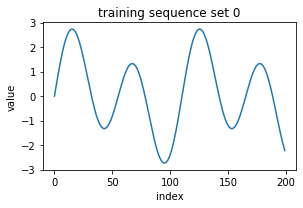

In [3]:
train_sequence_1 = sum_of_sines(200, 0.057, 0, [1, 2], [1, 2], [0, 0])

plt.figure(figsize=(8,3))
        
plt.subplot(1, 2, 1)
plt.plot(train_sequence_1)
plt.title('training sequence set 0')
plt.xlabel('index')
plt.ylabel('value')
plt.tight_layout()

plt.show()

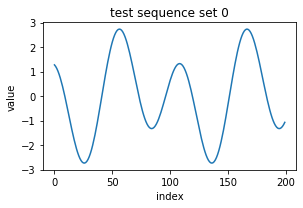

In [4]:
test_sequence_1 = sum_of_sines(200, 0.057, 400, [1, 2], [1, 2], [0, 0])

plt.figure(figsize=(8,3))
        
plt.subplot(1, 2, 1)
plt.plot(test_sequence_1)
plt.title('test sequence set 0')
plt.xlabel('index')
plt.ylabel('value')
plt.tight_layout()

plt.show()

Data set 1 is a harder challenge that uses 4 waves. For this set, we set freqs to (1.1, 1.7, 3.1, 7), amps to (1, 2, 2, 3), and we again left all the phases at 0, so phases is (0,0,0,0).

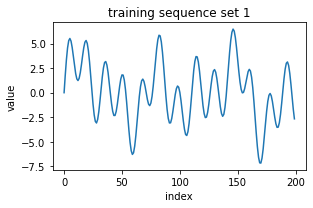

In [5]:
train_sequence_2 = sum_of_sines(200, 0.057, 0, [1.1, 1.7, 3.1, 7], [1, 2, 2, 3], [0, 0, 0, 0])

plt.figure(figsize=(8,3))
        
plt.subplot(1, 2, 1)
plt.plot(train_sequence_2)
plt.title('training sequence set 1')
plt.xlabel('index')
plt.ylabel('value')
plt.tight_layout()

plt.show()

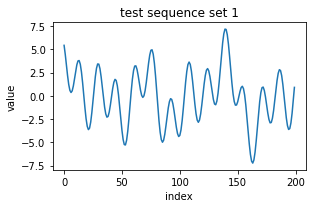

In [6]:
test_sequence_2 = sum_of_sines(200, 0.057, 400, [1.1, 1.7, 3.1, 7], [1, 2, 2, 3], [0, 0, 0, 0])

plt.figure(figsize=(8,3))
        
plt.subplot(1, 2, 1)
plt.plot(test_sequence_2)
plt.title('test sequence set 1')
plt.xlabel('index')
plt.ylabel('value')
plt.tight_layout()

plt.show()

## RNN Data Preparation

The mechanics for preparing data for RNNs in Keras are a little more complicated than what we’ve been working with so far, because we have to carry out a couple of reshaping steps in order to use all the library routines we want. We also need to extract our little windowed sublists, which we have to do ourselves since there aren’t any library routines to do it for us.

we want to normalize our data to get it into the range [0,1].
The MinMaxScaler from scikit-learn is the perfect tool for the job.

<img src='https://github.com/rahiakela/img-repo/blob/master/min-max-scaler.png?raw=1' width='800'/>

The MinMaxScaler, like most feature-wise normalizers,
reads all the values for each feature, finds the minimum and maximum, and re-scales the data to the range [0,1]. Each feature (a column in this example) is scaled independently.

Our sine wave data has only one feature, with many time steps, and it’s a 1D list (that is, it’s not a column as is expecting).
So let’s reshape our data into a column.

<img src='https://github.com/rahiakela/img-repo/blob/master/sequence-reshape.png?raw=1' width='800'/>

We can use reshape() to make this, where train_sequence and test_sequence can be the corresponding variables from either data set 0 or 2.



In [0]:
train_sequence = np.reshape(train_sequence_1, (train_sequence_1.shape[0], 1))
test_sequence = np.reshape(test_sequence_1, (test_sequence_1.shape[0], 1))

Now that we have our data in the right format to give to MinMaxScaler, we’ll make an instance of that object and then call its fit() routine on the training data. It will find the minimum and maximum values, and remember them. Then, as usual, we apply the transformation to both the training and test data by calling the scaler’s transform() method.

In [0]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
min_max_scaler.fit(train_sequence)
scaled_train_sequence = min_max_scaler.transform(train_sequence)
scaled_test_sequence = min_max_scaler.transform(test_sequence)

Note that, as usual, we first fit the scaling object to the training data, and then applied that transformation to the test (or validation) data.

Our object min_max_scaler remembers its transformation, so we’ll
later be able to apply its inverse to the output of our network, giving us a result in the same range as the input.

Now that our data is normalized, it’s time to create the little windowed sublists that make up our training and test data.

<img src='https://github.com/rahiakela/img-repo/blob/master/sequence-chopping.png?raw=1' width='800'/>

Once we have the windows, we can split them into the sample, which will be everything but the final value, and the target, which is that final value.

<img src='https://github.com/rahiakela/img-repo/blob/master/windowed-list.png?raw=1' width='800'/>

Building these windows is a common operation when working with
RNNs.

In [0]:
def samples_and_targets_from_sequence(sequence, window_size):
  '''
  Return lists of samples and targets built from overlapping
  windows of the given size. Windows start at the beginning of
  the input sequence and move right by 1 element.
  '''
  samples = []
  targets = []
  # i is starting position
  for i in range(sequence.shape[0] - window_size):
    # sub-list of elements
    sample = sequence[i: i + window_size]
    # element following sample
    target = sequence[i + window_size]
    # append sample to list
    samples.append(sample)
    # append target to list
    targets.append(target[0])
  
  # return as Numpy arrays
  return (np.array(samples), np.array(targets))

We can now create our training and test data just by handing our scaled sequences to this routine. As before, we’ll assign the windowed training data to X_train and y_train and the windowed testing data to X_test and y_test. We’ll assume that the integer variable window_size has been set.

In [0]:
window_size = 4
(X_train, y_train) = samples_and_targets_from_sequence(scaled_train_sequence, window_size)
(X_test, y_test) = samples_and_targets_from_sequence(scaled_test_sequence, window_size)

The training and test data that we’re saving in X_train and X_test are 3D blocks. The X_train block is as deep as the number of windows that we were able to make (that is, the number of samples), and as tall as the window size itself (that is, the number of time steps). 

The block is as wide as the number of features we’re learning. Since we have only 1 feature in this dataset, the block is only 1 element wide.

This is the structure that we want for training RNNs in Keras. The depth of the block tells us the number of samples we’ll train with. The time steps are arranged vertically, and the features horizontally.

<img src='https://github.com/rahiakela/img-repo/blob/master/sequence-structure.png?raw=1' width='800'/>

The structure of data prepared for RNN training. We have
3 samples, each containing 2 features, which in turn hold 7 time steps. 

* (a)The X_train data set ready for learning by an RNN. 
* (b) The first sample from X_train is the slice of the block that is closest to us. Here it’s the elements labeled A through G. This can be represented as a 2D grid. 
* (c) The first feature in this sample is located in the leftmost column. 
* (d) The elements inside that column are the time steps corresponding to that feature.

We set up our pre-processing so that we now have our data in the proper shape.

<img src='https://github.com/rahiakela/img-repo/blob/master/sequence-shape.png?raw=1' width='800'/>

## Building and Training an RNN

We’ll create an extremely simple RNN that runs quickly, yet still
demonstrates all the basic principles. We’ll have one recurrent layer,
followed by one dense layer.

Note that the dense layer has no activation function listed. That’s because
we don’t want it to modify the value it computes, since that value is our
prediction. We can either say that we’ve left off the activation function,
or we’ve set it to the linear function.

When we make an LSTM layer, we specify the number of cells we want.
Because this will be our first layer of the network, we also have to supply
the input dimensions. 

As usual, we set the argument input_shape to the shape of one sample. From our discussion above, we know that each sample is a 2D grid whose height is the number of time steps (that’s the height of our window), and whose width is the number of features (we have just 1).

```python
lstm_layer = LSTM(3, input_shape=[window_size, 1])
```

If we don’t specify an activation function in a Dense layer, Keras defaults to None. This is good for us in this situation, because we don’t want the output to be squashed down to the range [0,1] or [−1,1] or any other range.
Just to be explicit, we’ll include a redundant assignment of None to the
activation function.

In [11]:
model = Sequential()
model.add(LSTM(3, input_shape=[window_size, 1]))
model.add(Dense(1, activation=None))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3)                 60        
_________________________________________________________________
dense (Dense)                (None, 1)                 4         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [0]:
# compile and train the model
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

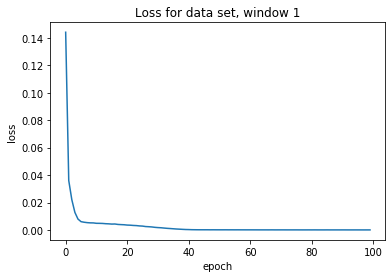

In [16]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss for data set, window '+str(1))
plt.show()

In [0]:
# compute predictions for both the training and test data.
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

As you know, we’ve applied the MinMaxScaler to our input data
(both training and test), transforming it from our original values to a
range more suitable for training. That means that the network’s predictions
are also transformed.

Because of this, we cannot directly compare our predictions with our
original data. In the case of a simple scaling, like we’re doing here,
that’s not a major issue. But if we perform a more complicated processing
step, then it could be very hard to mentally interpret the predicted
data.

The general solution is to inverse-transform the predicted data. Like most of scikit-learn’s transformation routines, MinMaxScaler come with a method called inverse_transform() that does just this.

In [0]:
# inverse-transform original targets
inverse_y_train = min_max_scaler.inverse_transform([y_train])
inverse_y_test = min_max_scaler.inverse_transform([y_test])

# inverse-transform predictions
inverse_y_train_predict = min_max_scaler.inverse_transform(y_train_predict)
inverse_y_test_predict = min_max_scaler.inverse_transform(y_test_predict)

Now that we have the predictions back in the original range of the data,
we can plot them with the original data and see how good our predictions
are. We can also use them to get a quick numerical summary of
accuracy using a measure called the root mean squared error, or RMS
error. This is a standard way to measure error that lets us compare
apples to apples when we look at multiple networks.

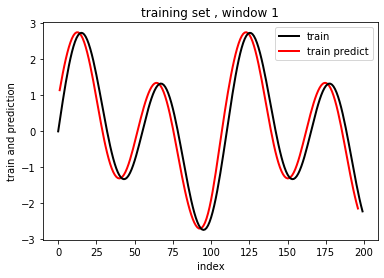

In [21]:
# plot training and predictions
window_size=1
plt.plot(train_sequence, label="train", color='black', linewidth=2, zorder=20)
skip_values = np.array(window_size*(np.nan,))
flat_predict = np.ravel(inverse_y_train_predict)
plot_predict = np.append(skip_values, flat_predict)
plt.plot(plot_predict, label="train predict", color='red', linewidth=2, zorder=10)
plt.legend(loc='best')
plt.xlabel('index')
plt.ylabel('train and prediction')
plt.title('training set , window '+str(window_size))    

plt.show()

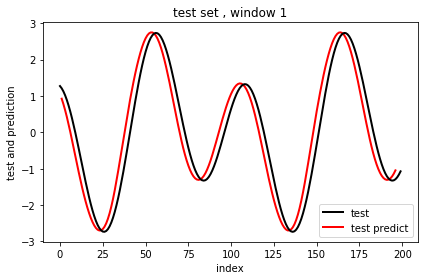

In [22]:
# plot test and predictions
plt.plot(test_sequence, label="test", color='black', linewidth=2, zorder=20)
skip_values = np.array(window_size*(np.nan,))
flat_predict = np.ravel(inverse_y_test_predict)
plot_predict = np.append(skip_values, flat_predict)
plt.plot(plot_predict, label="test predict", color='red', linewidth=2, zorder=10)
plt.legend(loc='best')
plt.xlabel('index')
plt.ylabel('test and prediction')
plt.title('test set , window '+str(window_size))
plt.tight_layout()

plt.show()

In [23]:
from sklearn.metrics import mean_squared_error

trainScore = math.sqrt(mean_squared_error(inverse_y_train[0], inverse_y_train_predict[:, 0]))
print('Training RMS error: {:.2f}'.format(trainScore))

testScore = math.sqrt(mean_squared_error(inverse_y_test[0], inverse_y_test_predict[:, 0]))
print('Test RMS error: {:.2f}'.format(testScore))

Training RMS error: 0.04
Test RMS error: 0.04


## Analyzing RNN Performance

Let’s try out our sine wave data on this tiny RNN.

In [0]:
random_seed = 42

In [0]:
def sum_of_upsloping_sines(number_of_steps, d_theta, skip_steps, freqs, amps, phases):
  '''Like sum_of_sines(), but always sloping upwards'''
  np.random.seed(42)
  values = []
  for step_num in range(number_of_steps):
      angle = d_theta * (step_num + skip_steps)
      sum = 0
      for wave in range(len(freqs)):
          y = amps[wave] * math.sin(freqs[wave]*(phases[wave] + angle))
          sum += y
      values.append(sum)
      if step_num > 0:
          sum_change = sum - prev_sum
          if sum_change < 0:
              values[-1] *= -1
              if step_num == 1:
                  values[-2] *= -1
      prev_sum = sum
  return np.array(values)

In [0]:
def make_data(data_sequence_number, training_length):
  training_sequence = test_sequence = []
  test_length = 200
  theta_step = .057
  if data_sequence_number == 0:
      freqs_list = [1, 2]
      amps_list = [1, 2]
      phases_list = [0, 0]
      data_maker = sum_of_sines
  elif data_sequence_number == 1:
      freqs_list = [1.1, 1.7, 3.1, 7]
      amps_list = [1,2,2,3]
      phases_list = [0,0,0,0]
      data_maker = sum_of_sines
  elif data_sequence_number == 2:
      freqs_list = [1.1, 1.7, 3.1, 7]
      amps_list = [1,2,2,3]
      phases_list = [0,0,0,0]
      data_maker = sum_of_upsloping_sines
  else:
      print("***** ERROR! Unknown data_sequence_number = ",data_sequence_number)
  training_sequence = data_maker(training_length, theta_step, 0, freqs_list, amps_list, phases_list)
  test_sequence = data_maker(test_length, theta_step, 2*training_length, freqs_list, amps_list, phases_list)
  return (training_sequence, test_sequence)

In [0]:
def show_data_sets(training_length):
  for i in range(0, 3):
    (training_sequence, test_sequence) = make_data(i, training_length)
    plt.figure(figsize=(8,3))
    
    plt.subplot(1, 2, 1)
    plt.plot(training_sequence)
    plt.title('training sequence, set '+str(i))
    plt.xlabel('index')
    plt.ylabel('value')
    
    plt.subplot(1, 2, 2)
    plt.plot(test_sequence)
    plt.title('test sequence, set '+str(i))
    plt.xlabel('index')
    plt.ylabel('value')
    
    plt.tight_layout()
    
    plt.show()

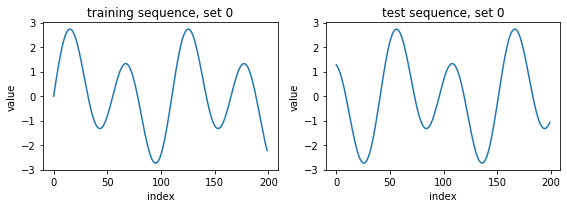

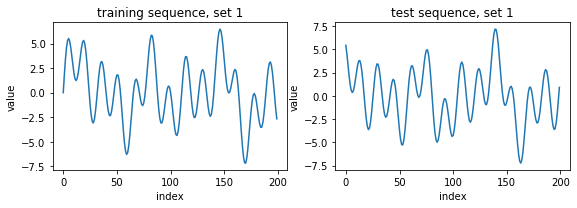

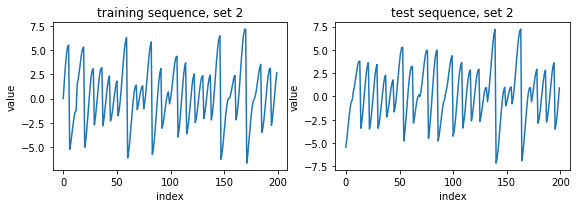

In [30]:
show_data_sets(training_length=200)

In [0]:
def scale_sequences(training_sequence, test_sequence):
  # reshape train and test sequences to form needed by MinMaxScaler
  training_sequence = np.reshape(training_sequence, (training_sequence.shape[0], 1))
  test_sequence = np.reshape(test_sequence, (test_sequence.shape[0], 1))
  Min_max_scaler = MinMaxScaler(feature_range=(0, 1))
  Min_max_scaler.fit(training_sequence)
  scaled_training_sequence = Min_max_scaler.transform(training_sequence)
  scaled_test_sequence = Min_max_scaler.transform(test_sequence)
  return (Min_max_scaler, scaled_training_sequence, scaled_test_sequence)

In [0]:
# chop up train and test sequences into overlapping windows of the given size
def chop_up_sequences(training_sequence, test_sequence, window_size):
  (X_train, y_train) = samples_and_targets_from_sequence(training_sequence, window_size)
  (X_test, y_test) = samples_and_targets_from_sequence(test_sequence, window_size)
  return (X_train, y_train, X_test, y_test)

In [0]:
def make_data_set(data_sequence_number, window_size, training_length):
  (training_sequence, test_sequence) = make_data(data_sequence_number, training_length)
  (Min_max_scaler, scaled_training_sequence, scaled_test_sequence) = scale_sequences(training_sequence, test_sequence)
  (X_train, y_train, X_test, y_test)= chop_up_sequences(scaled_training_sequence, scaled_test_sequence, window_size)
  return (Min_max_scaler, X_train, y_train, X_test, y_test, training_sequence, test_sequence)

In [0]:
# build and run the first model. 
def make_model(model_number, window_size):
  model = Sequential()
  if model_number == 0:
      model.add(LSTM(3, input_shape=[window_size, 1]))
      model.add(Dense(1, activation=None))
  elif model_number == 1:
      model.add(LSTM(3, return_sequences=True, input_shape=[window_size, 1]))
      model.add(LSTM(3))
      model.add(Dense(1, activation=None))
  elif model_number == 2:
      model.add(LSTM(9, return_sequences=True, input_shape=[window_size, 1]))
      model.add(LSTM(6, return_sequences=True))
      model.add(LSTM(3))
      model.add(Dense(1, activation=None))
  else:
      print("*** ERROR: make_model unknown model_number = ",model_number)
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [0]:
def build_and_compare(model_number, data_set_number, window_size, training_length, epochs):
  np.random.seed(random_seed)
  model = make_model(model_number, window_size)
  (Min_max_scaler, X_train, y_train, X_test, y_test, training_sequence, test_sequence) = \
      make_data_set(data_set_number, window_size, training_length)
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=0)
  
  # Predict 
  y_train_predict = np.ravel(model.predict(X_train))
  y_test_predict = np.ravel(model.predict(X_test))
  
  # invert transformation
  inverse_y_train_predict = Min_max_scaler.inverse_transform([y_train_predict])
  inverse_y_test_predict = Min_max_scaler.inverse_transform([y_test_predict])    
  
  plot_string = '-dataset-'+str(data_set_number)+'-window-'+str(window_size)+\
                  '-model_number-'+str(model_number)+'-length-'+str(training_length)+'-epochs-'+str(epochs)
      
  plt.plot(history.history['loss'])
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Loss for data set '+str(data_set_number)+', window '+str(window_size))
  
  plt.show()
  
  # plot training and predictions

  plt.plot(training_sequence, label="train", color='black', linewidth=2, zorder=20)
  skip_values = np.array(window_size*(np.nan,))
  flat_predict = np.ravel(inverse_y_train_predict)
  plot_predict = np.append(skip_values, flat_predict)
  plt.plot(plot_predict, label="train predict", color='red', linewidth=2, zorder=10)
  plt.legend(loc='best')
  plt.xlabel('index')
  plt.ylabel('train and prediction')
  plt.title('training set '+str(data_set_number)+', window '+str(window_size))    
  
  plt.show()
  
  plt.plot(test_sequence, label="test", color='black', linewidth=2, zorder=20)
  skip_values = np.array(window_size*(np.nan,))
  flat_predict = np.ravel(inverse_y_test_predict)
  plot_predict = np.append(skip_values, flat_predict)
  plt.plot(plot_predict, label="test predict", color='red', linewidth=2, zorder=10)
  plt.legend(loc='best')
  plt.xlabel('index')
  plt.ylabel('test and prediction')
  plt.title('test set '+str(data_set_number)+', window '+str(window_size))
  plt.tight_layout()
  
  plt.show()

### Step-1.1

Let’s arbitrarily start with a window size of 3 steps. This means each
sample will have 3 values, and we’ll ask the network to predict the
one that comes after. We’ll always provide that value as the target, so
during training the system can learn to match that value, and during
testing we can see how well we did.

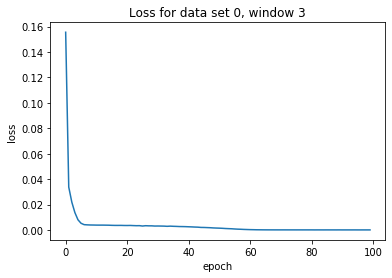

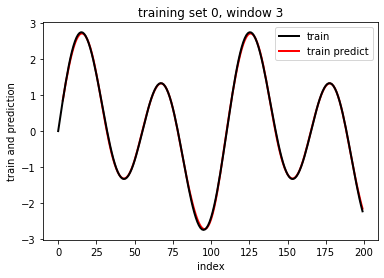

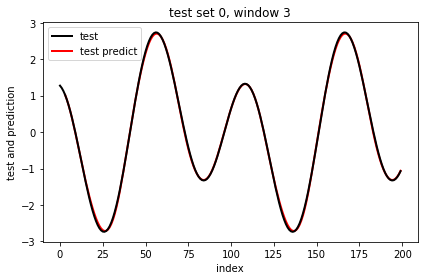

In [38]:
build_and_compare(model_number=0, data_set_number=0, window_size=3, training_length=200, epochs=100)

The loss drops quickly to about 0.06, then more gently to something
close to zero around epoch 8, and then over the next 60 epochs or so
it continues to drop, finally hitting a value visually hard to distinguish
from zero at around epoch 80.

### Step 1.2

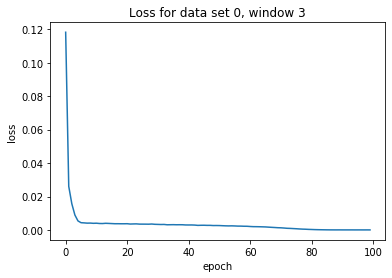

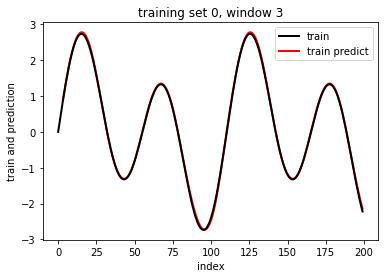

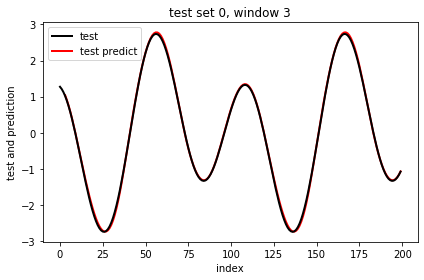

In [39]:
build_and_compare(model_number=0, data_set_number=0, window_size=3, training_length=200, epochs=100)

### Step 1.3

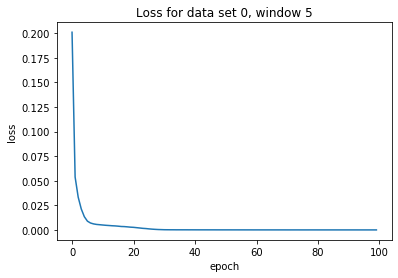

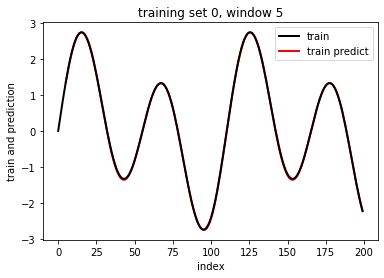

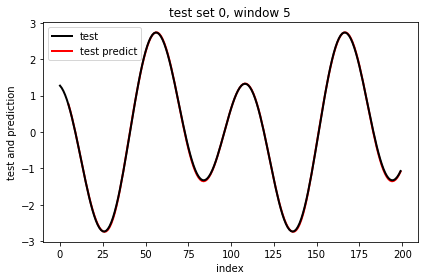

In [40]:
build_and_compare(model_number=0, data_set_number=0, window_size=5, training_length=200, epochs=100)

### Step 2.1

Even though 3 steps did a good job predicting our test data, let’s go
the other way and crank up our window size up to 5 time steps. Since
we’re just trying to get a feeling for things now, rather than carry out a
detailed analysis, we’ll skip the curve showing the training predictions,
and go straight to the loss curve and test predictions.

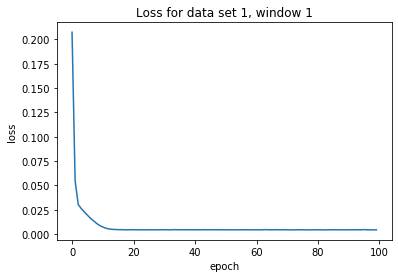

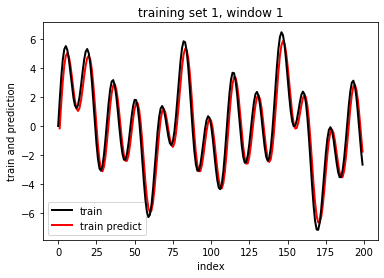

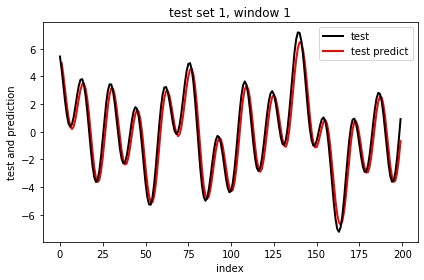

In [41]:
build_and_compare(model_number=0, data_set_number=1, window_size=1, training_length=200, epochs=100)

### Step 2.2

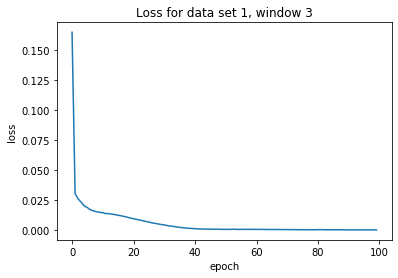

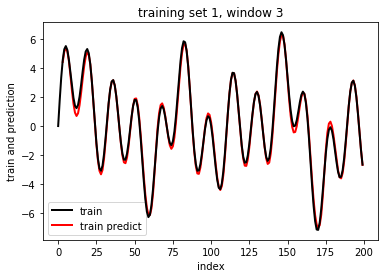

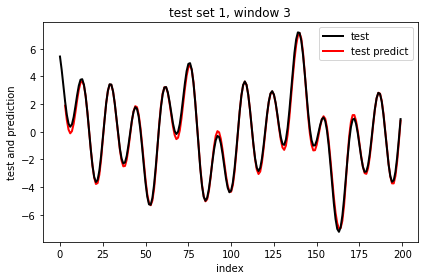

In [42]:
build_and_compare(model_number=0, data_set_number=1, window_size=3, training_length=200, epochs=100)

### Step 2.3

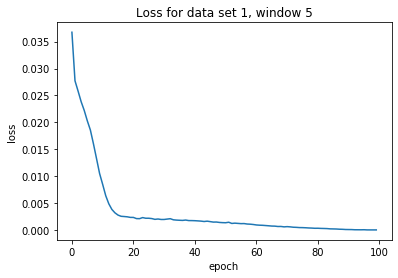

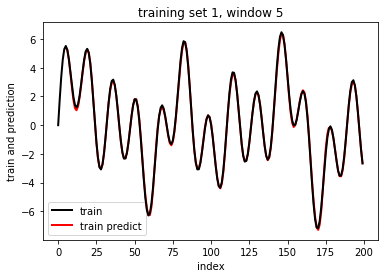

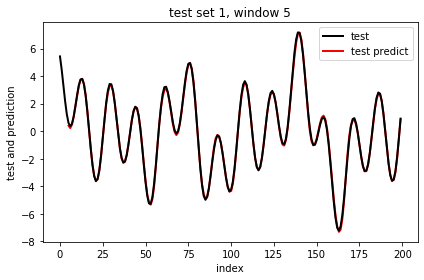

In [43]:
build_and_compare(model_number=0, data_set_number=1, window_size=5, training_length=200, epochs=100)

## More Complex Dataset

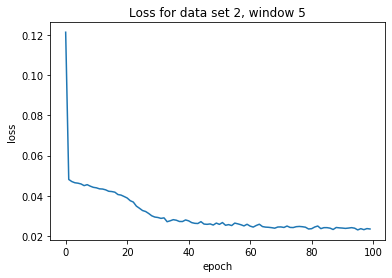

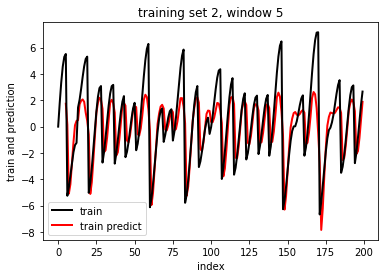

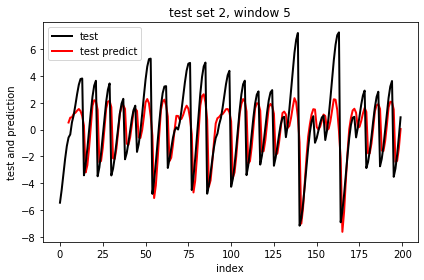

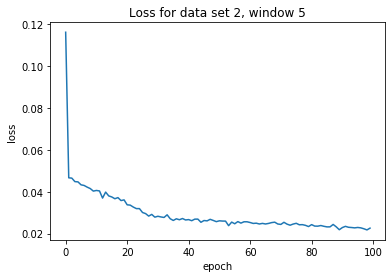

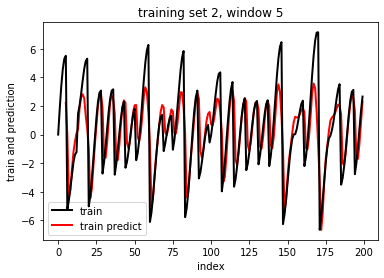

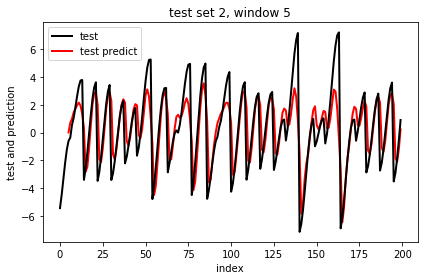

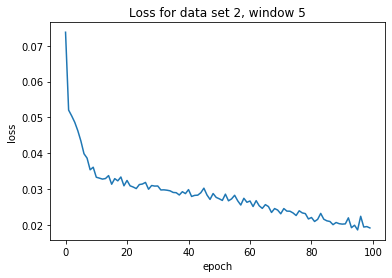

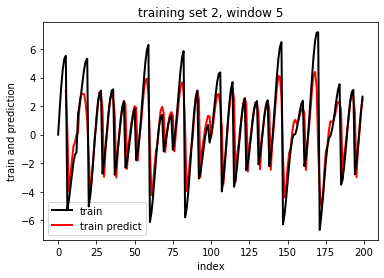

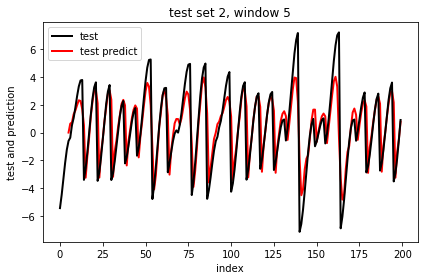

In [0]:
build_and_compare(model_number=0, data_set_number=2, window_size=5, training_length=200, epochs=100)

build_and_compare(model_number=1, data_set_number=2, window_size=5, training_length=200, epochs=100)

build_and_compare(model_number=2, data_set_number=2, window_size=5, training_length=200, epochs=100)
build_and_compare(model_number=2, data_set_number=2, window_size=13, training_length=2000, epochs=100)
build_and_compare(model_number=2, data_set_number=2, window_size=13, training_length=20000, epochs=100)